Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

이전까지는 fully connected network였다면, 이번 과제에서는 convnet으로 만드는 것이 목표이다.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [12]:
# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

이미지 데이터를 convolution에 맞게끔 channel 항목을 추가.(흑백으로 channel은 1)

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

convolution layer가 있는 두개의 network를 만든다. 그리고, 뒤이어 fully connected layer가 온다.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) # assignment 3에서는 image size를 곱해서 flat하게 했는데, 그와는 다르다는 것을 인지할 것.
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal( # layer 1 : convolution layer1. 4D(filter_height, filter_width, in_channels, out_channels)->3D까지는 머리로 이해할 수 있으나, 4d는 헷갈리네.
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal( # layer 2 : convolution layer2. 4D.
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal( # layer 3 : fully connected layer. 4D->2D filter. 28//4=7. 7*7*16
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal( # layer 4 : maybe.. non-hidden layer?
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  # layer1 빼고는 천부 biases가 1.0
  
  # Model.
  def model(data):
    # conv2d : computes 2-d convolution given 4-d input and filter tensors (MUST read tensorflow docs)
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME') # conv layer1 / same padding. stride[1,2,2,1]
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME') #conv layer2
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list() # For building fully connected layer, reshape the result. 
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) # [?,size*size*depth]
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases) # fully connected
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [22]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.688577
Minibatch accuracy: 12.5%
Validation accuracy: 9.9%
Minibatch loss at step 50: 2.272186
Minibatch accuracy: 6.2%
Validation accuracy: 10.3%
Minibatch loss at step 100: 1.598921
Minibatch accuracy: 43.8%
Validation accuracy: 52.9%
Minibatch loss at step 150: 1.199168
Minibatch accuracy: 62.5%
Validation accuracy: 70.6%
Minibatch loss at step 200: 0.779530
Minibatch accuracy: 68.8%
Validation accuracy: 76.7%
Minibatch loss at step 250: 1.292048
Minibatch accuracy: 68.8%
Validation accuracy: 77.8%
Minibatch loss at step 300: 0.989322
Minibatch accuracy: 87.5%
Validation accuracy: 78.5%
Minibatch loss at step 350: 1.392429
Minibatch accuracy: 62.5%
Validation accuracy: 75.5%
Minibatch loss at step 400: 0.684252
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 450: 0.425752
Minibatch accuracy: 93.8%
Validation accuracy: 81.0%
Minibatch loss at step 500: 0.694161
Minibatch accuracy: 75.0%
Validation accuracy: 81.1%
Min

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

max pooling으로 stride 2, kernel(patch) size 2로 바꿔보아라.

---

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) # assignment 3에서는 image size를 곱해서 flat하게 했는데, 그와는 다르다는 것을 인지할 것.
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal( # layer 1 : convolution layer1. 4D(filter_height, filter_width, in_channels, out_channels)->3D까지는 머리로 이해할 수 있으나, 4d는 헷갈리네.
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal( # layer 2 : convolution layer2. 4D.
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal( # layer 3 : fully connected layer. 4D->2D filter. 28//4=7. 7*7*16
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal( # layer 4 : maybe.. non-hidden layer?
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  # layer1 빼고는 천부 biases가 1.0
  
  # Model.
  def model(data):
    # conv2d : computes 2-d convolution given 4-d input and filter tensors (MUST read tensorflow docs)
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') # conv | layer1 / same padding. stride[1,1,1,1]
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # <------ max pooling
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME') #conv | layer2
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # <------ max pooling
    
    shape = hidden.get_shape().as_list() # For building fully connected layer, reshape the result. 
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) # [?,size*size*depth]
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases) # fully connected
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.756979
Minibatch accuracy: 12.5%
Validation accuracy: 10.2%
Minibatch loss at step 50: 2.076845
Minibatch accuracy: 18.8%
Validation accuracy: 18.8%
Minibatch loss at step 100: 1.464158
Minibatch accuracy: 43.8%
Validation accuracy: 60.2%
Minibatch loss at step 150: 0.864797
Minibatch accuracy: 75.0%
Validation accuracy: 68.4%
Minibatch loss at step 200: 0.737107
Minibatch accuracy: 56.2%
Validation accuracy: 77.3%
Minibatch loss at step 250: 1.427019
Minibatch accuracy: 81.2%
Validation accuracy: 76.9%
Minibatch loss at step 300: 0.613087
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 350: 1.477365
Minibatch accuracy: 68.8%
Validation accuracy: 75.6%
Minibatch loss at step 400: 0.612715
Minibatch accuracy: 81.2%
Validation accuracy: 80.3%
Minibatch loss at step 450: 0.380266
Minibatch accuracy: 87.5%
Validation accuracy: 82.3%
Minibatch loss at step 500: 0.490234
Minibatch accuracy: 81.2%
Validation accuracy: 81.9%
M

 Convolution stride=1, max pooling stride=2. A little bit improve.

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

convnet을 이용해서 최고의 성능을 만들어볼 것. LeNet5 아키텍처를 참고하고, dropout이나 learning rate decay 등 여러가지 배운 것들을 활용해 비교해가면서 해볼 것.

---

L2 Regularization을 적용시켜보자. (step : 3001로 늘림)

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) # assignment 3에서는 image size를 곱해서 flat하게 했는데, 그와는 다르다는 것을 인지할 것.
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal( # layer 1 : convolution layer1. 4D(filter_height, filter_width, in_channels, out_channels)->3D까지는 머리로 이해할 수 있으나, 4d는 헷갈리네.
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal( # layer 2 : convolution layer2. 4D.
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal( # layer 3 : fully connected layer. 4D->2D filter. 28//4=7. 7*7*16
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal( # layer 4 : maybe.. non-hidden layer?
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  # layer1 빼고는 천부 biases가 1.0
  
  # Model.
  def model(data):
    # conv2d : computes 2-d convolution given 4-d input and filter tensors (MUST read tensorflow docs)
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') # conv | layer1 / same padding. stride[1,1,1,1]
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # <------ max pooling
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME') #conv | layer2
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # <------ max pooling
    
    shape = hidden.get_shape().as_list() # For building fully connected layer, reshape the result. 
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) # [?,size*size*depth]
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases) # fully connected
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
  loss = tf.reduce_mean(loss + beta_regul * (tf.nn.l2_loss(layer1_weights)+tf.nn.l2_loss(layer2_weights)+tf.nn.l2_loss(layer3_weights)+tf.nn.l2_loss(layer4_weights)))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.034549
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 100: 1.778887
Minibatch accuracy: 50.0%
Validation accuracy: 59.1%
Minibatch loss at step 200: 0.924733
Minibatch accuracy: 81.2%
Validation accuracy: 77.8%
Minibatch loss at step 300: 0.778236
Minibatch accuracy: 81.2%
Validation accuracy: 81.1%
Minibatch loss at step 400: 0.726420
Minibatch accuracy: 87.5%
Validation accuracy: 80.9%
Minibatch loss at step 500: 0.743777
Minibatch accuracy: 87.5%
Validation accuracy: 82.6%
Minibatch loss at step 600: 0.521454
Minibatch accuracy: 93.8%
Validation accuracy: 83.8%
Minibatch loss at step 700: 0.638216
Minibatch accuracy: 87.5%
Validation accuracy: 84.5%
Minibatch loss at step 800: 0.515049
Minibatch accuracy: 87.5%
Validation accuracy: 84.9%
Minibatch loss at step 900: 1.309892
Minibatch accuracy: 68.8%
Validation accuracy: 84.3%
Minibatch loss at step 1000: 0.912396
Minibatch accuracy: 75.0%
Validation accuracy: 85.2%

L2 Regulation적용 결과 성능 소폭 증가. beta의 최적 수치를 찾아보기 위해 아래와 같은 것을 수행한다.(3001step은 오래걸려서 1001로 테스트. 1001도 오래걸릴 듯 ㅠㅠ)

(참고로 step수를 1001로 했을 때는 오히려 감소하거나 비슷했다.)

In [11]:
num_steps = 1001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
best_accr = 0.0
best_beta = 0.0

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    cur_accr = accuracy(test_prediction.eval(), test_labels)  # <-------- modified
    accuracy_val.append(cur_accr) # <-------- modified
    if cur_accr > best_accr:
        best_accr = cur_accr
        best_beta = regul

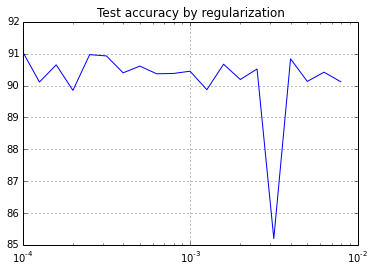

best accuracy : 91.060000 
beta : 0.000100


In [17]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization')
plt.show()
print('best accuracy : %f '%best_accr)
print('beta : %f' %best_beta)

L2 Regularization(beta:0.0001) with dropout(0.8)

In [18]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) # assignment 3에서는 image size를 곱해서 flat하게 했는데, 그와는 다르다는 것을 인지할 것.
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal( # layer 1 : convolution layer1. 4D(filter_height, filter_width, in_channels, out_channels)->3D까지는 머리로 이해할 수 있으나, 4d는 헷갈리네.
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal( # layer 2 : convolution layer2. 4D.
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal( # layer 3 : fully connected layer. 4D->2D filter. 28//4=7. 7*7*16
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal( # layer 4 : maybe.. non-hidden layer?
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  # layer1 빼고는 천부 biases가 1.0
  
  # Model.
  def model(data):
    # conv2d : computes 2-d convolution given 4-d input and filter tensors (MUST read tensorflow docs)
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') # conv | layer1 / same padding. stride[1,1,1,1]
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # <------ max pooling
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME') #conv | layer2
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME') # <------ max pooling
    
    hidden = tf.nn.dropout(hidden, 0.8) # apply dropout on hidden layer
    
    shape = hidden.get_shape().as_list() # For building fully connected layer, reshape the result. 
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) # [?,size*size*depth]
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases) # fully connected
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
  loss = tf.reduce_mean(loss + beta_regul * (tf.nn.l2_loss(layer1_weights)+tf.nn.l2_loss(layer2_weights)+tf.nn.l2_loss(layer3_weights)+tf.nn.l2_loss(layer4_weights)))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [20]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 250 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.629057
Minibatch accuracy: 6.2%
Validation accuracy: 9.9%
Minibatch loss at step 250: 1.645260
Minibatch accuracy: 56.2%
Validation accuracy: 76.3%
Minibatch loss at step 500: 0.746436
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Minibatch loss at step 750: 1.199659
Minibatch accuracy: 75.0%
Validation accuracy: 81.9%
Minibatch loss at step 1000: 0.883666
Minibatch accuracy: 75.0%
Validation accuracy: 83.8%
Minibatch loss at step 1250: 1.181014
Minibatch accuracy: 81.2%
Validation accuracy: 84.9%
Minibatch loss at step 1500: 0.690650
Minibatch accuracy: 87.5%
Validation accuracy: 85.0%
Minibatch loss at step 1750: 0.766883
Minibatch accuracy: 81.2%
Validation accuracy: 84.4%
Minibatch loss at step 2000: 1.035325
Minibatch accuracy: 81.2%
Validation accuracy: 85.5%
Minibatch loss at step 2250: 1.405232
Minibatch accuracy: 62.5%
Validation accuracy: 86.2%
Minibatch loss at step 2500: 0.943775
Minibatch accuracy: 75.0%
Validation accuracy: 8

Regulation과 dropout이 같이 쓰이면 아무래도 learning rate가 줄어드니까 학습에 필요한 step이 더 많이 필요.
그래서 같은 step수로 학습했을때 성능이 더 줄어드는 것처럼 보인다.

적당한 learning rate를 찾는 것이 그만큼 어려움. ㅠ